In [29]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install shap

     -------------------------------------- 453.1/453.1 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd 
import numpy as np 
import time #Calcular o tempo

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE #Para balancear os dados - faremos só no treino

from sklearn.feature_selection import RFE,SequentialFeatureSelector #Seleção de variáveis

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,cohen_kappa_score,roc_auc_score,roc_curve,recall_score,precision_score


import plotly.express as px
import matplotlib.pyplot as plt
import shap
#from sklearn.pipeline import make_pipeline


In [2]:
pd.set_option('display.max_columns',  30)

In [3]:
df = pd.read_csv(r'..\Dados\Kaggle\modelar.csv', sep = ';')
df.head(2)

,PatientId,AppointmentID,Genero,Agendamento,Consulta,Idade,BairroUBS,BolsaFamilia,Hipertencao,Diabetes,Alcoolatra,Deficiente,SMS_received,No-show,StatusFalta,StatusComparecimento,DiaAgendamento,DiaConsulta,dia_semana,TempoEspera,Feminimo,PrecipitaçãoMediaAG,TempMaxAG,TempMinAG,Chuva,Qtd_doencas,Faixa_Idade
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Compareceu,2016-04-29,2016-04-29,Sex,0,1,0.008333,22.866667,22.529167,1,1,60 anos ou mais
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Compareceu,2016-04-29,2016-04-29,Sex,0,0,0.008333,22.866667,22.529167,1,0,Entre 30 e 59 anos


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             110521 non-null  float64
 1   AppointmentID         110521 non-null  int64  
 2   Genero                110521 non-null  object 
 3   Agendamento           110521 non-null  object 
 4   Consulta              110521 non-null  object 
 5   Idade                 110521 non-null  int64  
 6   BairroUBS             110521 non-null  object 
 7   BolsaFamilia          110521 non-null  int64  
 8   Hipertencao           110521 non-null  int64  
 9   Diabetes              110521 non-null  int64  
 10  Alcoolatra            110521 non-null  int64  
 11  Deficiente            110521 non-null  int64  
 12  SMS_received          110521 non-null  int64  
 13  No-show               110521 non-null  object 
 14  StatusFalta           110521 non-null  int64  
 15  

### Escolhendo a base para usar no modelo 
**Na segunda versão testar com variaveis dummies para indicar o NomeUnidade**


In [5]:
#Dummie para o dia da semana (consulta)
df = pd.concat([df, pd.get_dummies(df['dia_semana'])], axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             110521 non-null  float64
 1   AppointmentID         110521 non-null  int64  
 2   Genero                110521 non-null  object 
 3   Agendamento           110521 non-null  object 
 4   Consulta              110521 non-null  object 
 5   Idade                 110521 non-null  int64  
 6   BairroUBS             110521 non-null  object 
 7   BolsaFamilia          110521 non-null  int64  
 8   Hipertencao           110521 non-null  int64  
 9   Diabetes              110521 non-null  int64  
 10  Alcoolatra            110521 non-null  int64  
 11  Deficiente            110521 non-null  int64  
 12  SMS_received          110521 non-null  int64  
 13  No-show               110521 non-null  object 
 14  StatusFalta           110521 non-null  int64  
 15  

In [7]:
df_mod = df[['Idade','Alcoolatra', 'Deficiente', 'SMS_received', 'StatusFalta',
        'TempoEspera', 'Feminimo', 'PrecipitaçãoMediaAG', 'TempMaxAG', 'TempMinAG', 'Chuva', 'Qtd_doencas'
      , 'Qua', 'Qui',  'Sab', 'Seg', 'Sex', 'Ter']]

In [8]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Idade                110521 non-null  int64  
 1   Alcoolatra           110521 non-null  int64  
 2   Deficiente           110521 non-null  int64  
 3   SMS_received         110521 non-null  int64  
 4   StatusFalta          110521 non-null  int64  
 5   TempoEspera          110521 non-null  int64  
 6   Feminimo             110521 non-null  int64  
 7   PrecipitaçãoMediaAG  110521 non-null  float64
 8   TempMaxAG            110521 non-null  float64
 9   TempMinAG            110521 non-null  float64
 10  Chuva                110521 non-null  int64  
 11  Qtd_doencas          110521 non-null  int64  
 12  Qua                  110521 non-null  uint8  
 13  Qui                  110521 non-null  uint8  
 14  Sab                  110521 non-null  uint8  
 15  Seg              

In [9]:
SEED = 2024

In [10]:
y = df['StatusFalta']

X = df_mod.drop('StatusFalta', axis = 1)

## Vamos balancear e normalizar os dados

In [11]:
sm = SMOTE(random_state=SEED)
X_balanceado, y_balanceado = sm.fit_resample(X, y)

In [12]:
X_balanceado.shape

(176414, 17)

In [13]:
#Vamos normaliza-los 
colunas_X = X.columns

min_max_scale = preprocessing.MinMaxScaler()
X_transformado = min_max_scale.fit_transform(X_balanceado)
X_mod = pd.DataFrame(X_transformado, columns=colunas_X)

In [14]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_mod, y_balanceado, test_size = .2, random_state = SEED)

In [16]:
print('Treino::',X_treino.shape[0])
print('Teste::',X_teste.shape[0])

Treino:: 141131
Teste:: 35283


In [17]:
pd.concat([X_treino,y_treino], axis = 1)['StatusFalta'].value_counts(normalize = True)

0    0.500039
1    0.499961
Name: StatusFalta, dtype: float64

In [18]:
pd.concat([X_teste,y_teste], axis = 1)['StatusFalta'].value_counts(normalize = True)

1    0.500156
0    0.499844
Name: StatusFalta, dtype: float64

## Seleçao de variáveis com os dados de treino

In [18]:
#Definindo os hyperparâmetros
hyper_params = [{'n_features_to_select': list(range(1,len(X_treino.columns) + 1))}]

#Instanciando o modelo de Regressão Logística
rfe_select = RFE(RandomForestClassifier(), step = 1)

#Random Search
rs_select_feature = RandomizedSearchCV(estimator = rfe_select,
                                     param_distributions = hyper_params, 
                                     scoring = 'accuracy', cv = 5,
                                     n_iter = 15, 
                                     verbose = 1,
                                     random_state = 2024,                           
                                      return_train_score = True).fit(X_treino,y_treino)

#Buscando o melhor modelo de seleção de variáveis
best_model_grid_recall = rs_select_feature.best_estimator_

In [60]:
best_model_grid_recall

RFE(estimator=RandomForestClassifier(), n_features_to_select=16)

In [21]:
variaveis_selecionadas = best_model_grid_recall.get_feature_names_out()

['Idade',
 'Alcoolatra',
 'Deficiente',
 'SMS_received',
 'TempoEspera',
 'Feminimo',
 'PrecipitaçãoMediaAG',
 'TempMaxAG',
 'TempMinAG',
 'Chuva',
 'Qtd_doencas',
 'Qua',
 'Qui',
 'Seg',
 'Sex',
 'Ter']

## Das variáveis escolhidas 16 entraram
['Idade', 'Alcoolatra', 'Deficiente', 'SMS_received', 'TempoEspera',
       'Feminimo', 'PrecipitaçãoMediaAG', 'TempMaxAG', 'TempMinAG',
       'Chuva', 'Qtd_doencas', 'Qua', 'Qui', 'Seg', 'Sex', 'Ter']

In [22]:
X_teste = X_teste[variaveis_selecionadas]
X_treino = X_treino[variaveis_selecionadas]

## Regressão Logística

In [23]:
inicio = time.time()
reg_log = LogisticRegressionCV(cv= 10, scoring='accuracy', solver='lbfgs', max_iter=1000)

#Ajustando aos dados
ajust_log = reg_log.fit(X_treino, y_treino)

fim = time.time()
print('Tempo de processamento',fim - inicio)

Tempo de processamento 34.65189051628113


In [33]:
#Valor predito 
y_predito_treino = ajust_log.predict(X_treino)
y_predito_teste = ajust_log.predict(X_teste)

In [34]:
previsao_log = pd.DataFrame(ajust_log.predict_proba(X_teste)).rename({0: 'prob_0', 1:'prob_1'}, axis = 1)
previsao_log[ 'predito_teste'] =  y_predito_teste
previsao_log

,prob_0,prob_1,predito_teste
0,0.533119,0.466881,0
1,0.002449,0.997551,1
2,0.399972,0.600028,1
3,0.003876,0.996124,1
4,0.762553,0.237447,0
...,...,...,...
35278,0.410207,0.589793,1
35279,0.493543,0.506457,1
35280,0.427488,0.572512,1
35281,0.480466,0.519534,1


In [35]:
#MATRIZ DE CONFUSÃO manual TESTE
pd.crosstab(list(y_teste.replace({0:'Real_0', 1:'Real_1'})), y_predito_teste)

col_0,0,1
row_0,,
Real_0,13074,4562
Real_1,8115,9532


In [36]:
#Medidas de performance
#accuracy_score

medidas_log = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['Logística_teste', 'Logística_treino'])
medidas_log 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
Logística_teste,0.640705,0.676316,0.540148,0.281455,0.640737
Logística_treino,0.640851,0.678192,0.535969,0.281691,0.640843


## Árvore de Decisão

Arvore livre foi até 43 de profundidade, mas overfitou 

In [96]:
arvore_livre = DecisionTreeClassifier(random_state = SEED)

#Ajustando aos dados
ajust_arvore = arvore_livre.fit(X_treino, y_treino)

In [97]:
y_predito_teste = ajust_arvore.predict(X_teste)
y_predito_treino = ajust_arvore.predict(X_treino)

In [98]:
#Medidas de performance
#accuracy_score

medidas_arvore = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['Árvore_teste', 'Árvore_treino'])
medidas_arvore 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
Árvore_teste,0.790891,0.785551,0.800419,0.581779,0.790888
Árvore_treino,0.927443,0.936785,0.916738,0.854886,0.927442


In [30]:
print('Profundidade máxima:',ajust_arvore.get_depth())

Profundidade máxima: 43


In [99]:
print('Profundidades testadas:',list(range(20,40))) # Na primeira versão deu 50 e já super ajustou

Profundidades testadas: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [108]:
#Grrid Search para a profundidade da árvore 

hyper_params = [{'max_depth': list(range(10,20))}]


#Random Search
rs_select_feature = RandomizedSearchCV(estimator = arvore_livre,
                                     param_distributions = hyper_params, 
                                     scoring = 'accuracy', cv = 5,
                                     n_iter = 8, 
                                     verbose = 1,
                                     random_state = 2024,                           
                                     return_train_score = True).fit(X_treino,y_treino)

#Buscando o melhor modelo de seleção de variáveis
best_model_grid_recall = rs_select_feature.best_estimator_
best_model_grid_recall

Fitting 5 folds for each of 8 candidates, totalling 40 fits


DecisionTreeClassifier(max_depth=19, random_state=9704)

In [116]:
pd.DataFrame(rs_select_feature.cv_results_)[['params','mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
0,{'max_depth': 12},0.721089,0.742162
1,{'max_depth': 17},0.754739,0.823104
2,{'max_depth': 15},0.741496,0.788234
3,{'max_depth': 16},0.748149,0.805619
4,{'max_depth': 11},0.713366,0.729744
5,{'max_depth': 14},0.735501,0.771861
6,{'max_depth': 13},0.726864,0.755922
7,{'max_depth': 19},0.765275,0.857336


In [26]:
inicio = time.time()
mod_arvore = DecisionTreeClassifier(max_depth=15, random_state = SEED)

#Ajustando aos dados
mod_arvore = mod_arvore.fit(X_treino, y_treino)
fim = time.time()

print('Tempo de processamento:', fim -inicio )

#Predição
y_predito_teste = mod_arvore.predict(X_teste)
y_predito_treino = mod_arvore.predict(X_treino)

Tempo de processamento: 0.5609230995178223


In [38]:
#Medidas de performance
#accuracy_score

medidas_arvore = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['TreeTunada_teste', 'TreeTunada_treino'])
medidas_arvore 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
TreeTunada_teste,0.742596,0.726025,0.779509,0.485179,0.742584
TreeTunada_treino,0.782436,0.762761,0.819827,0.564875,0.782439


## Naive Bayes

In [28]:
gausian = GaussianNB() 
multi = MultinomialNB() #modelo escolhido
CNB = ComplementNB()

In [41]:
print('Gausian:',cross_val_score(gausian, X_treino, y_treino,scoring='accuracy').mean())
print('multi:',cross_val_score(multi, X_treino, y_treino,scoring='accuracy').mean())
print('CNB:',cross_val_score(CNB, X_treino, y_treino,scoring='accuracy').mean())


Gausian: 0.5544635721438134
multi: 0.6050052804111847
CNB: 0.6050052806622093


In [29]:
#Ajustando aos dados com o modelo menos pior
inicio = time.time()
multi = MultinomialNB() #modelo escolhido
ajust_naive = multi.fit(X_treino, y_treino)
fim = time.time()

print('Tempo de processamento: ', fim - inicio)

Tempo de processamento:  0.03882098197937012


In [43]:
y_predito_teste = ajust_naive.predict(X_teste)
y_predito_treino = ajust_naive.predict(X_treino)

In [44]:
#Medidas de performance
#accuracy_score

medidas_naive = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['Naive_teste', 'Naive_treino'])
medidas_naive 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
Naive_teste,0.603293,0.616272,0.548138,0.206614,0.603311
Naive_treino,0.605225,0.616995,0.554762,0.210444,0.605221


## Random Florest

In [30]:
floresta = RandomForestClassifier(random_state = SEED)
ajust_arvore = floresta.fit(X_treino, y_treino)

In [39]:
y_predito_teste = ajust_arvore.predict(X_teste)
y_predito_treino = ajust_arvore.predict(X_treino)

In [40]:
medidas_rf = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['RandomForest_teste', 'RandomForest_treino'])
medidas_rf 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
RandomForest_teste,0.808633,0.797077,0.828243,0.617261,0.808627
RandomForest_treino,0.927422,0.920826,0.935247,0.854844,0.927423


### Tunando a floresta

In [99]:
hyper_florest = { 'n_estimators': list(range(300, 550, 100)),
                 'max_features': ['sqrt', 'log2'], 
                 'max_depth' : list(range(13,17))
    
}

In [101]:
tamanho = 1
for valores in hyper_florest.values():
    tamanho = tamanho * len(valores) 
    
print('Combinações possíveis: ',tamanho)

Combinações possíveis:  24


In [102]:
rs_floresta = RandomizedSearchCV( estimator = floresta, 
                                 param_distributions = hyper_florest, 
                                 scoring = 'accuracy', 
                                 n_jobs = -1, 
                                 cv = 5,
                                 n_iter = 20,
                                 return_train_score = True,
                                 verbose = 1,
                                 random_state = 2024,
                                 refit = 'KS'
).fit(X_treino, y_treino)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [104]:
pd.DataFrame(rs_floresta.cv_results_)[['param_n_estimators', 'param_max_features', 'param_max_depth', 'mean_test_score', 'mean_train_score']].sort_values('mean_test_score', ascending = False)

,param_n_estimators,param_max_features,param_max_depth,mean_test_score,mean_train_score
2,500,log2,16,0.775159,0.832188
4,500,sqrt,16,0.775159,0.832188
5,400,sqrt,16,0.775138,0.832145
14,300,log2,16,0.775067,0.832195
11,300,sqrt,16,0.775067,0.832195
3,400,sqrt,15,0.767507,0.812623
9,400,log2,15,0.767507,0.812623
12,300,sqrt,15,0.767507,0.812653
7,300,log2,15,0.767507,0.812653
0,500,log2,15,0.767124,0.812407


In [35]:
tunada_floresta = RandomForestClassifier(random_state = SEED, 
                                         n_estimators = 400,
                                         max_features = 'log2', 
                                         max_depth = 14)
inicio = time.time()
ajust_arvore = tunada_floresta.fit(X_treino, y_treino)
fim = time.time()
print('Tempo de processamento: ', fim - inicio)

Tempo de processamento:  57.65796422958374


In [21]:
y_predito_teste = ajust_arvore.predict(X_teste)
y_predito_treino = ajust_arvore.predict(X_treino)

In [22]:
medidas_rf = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['RandomForest_teste', 'RandomForest_treino'])
medidas_rf 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
RandomForest_teste,0.760309,0.728448,0.830283,0.520598,0.760288
RandomForest_treino,0.787928,0.751878,0.859439,0.575860,0.787933


In [28]:
pd.DataFrame({'Variáveis':ajust_arvore.feature_names_in_,'Importâncias':ajust_arvore.feature_importances_}).sort_values('Importâncias', ascending = False)

,Variáveis,Importâncias
4,TempoEspera,0.453357
0,Idade,0.152998
8,TempMinAG,0.079173
7,TempMaxAG,0.073961
6,PrecipitaçãoMediaAG,0.066012
10,Qtd_doencas,0.028016
5,Feminimo,0.026802
3,SMS_received,0.023657
9,Chuva,0.019286
13,Seg,0.013854


## Light GBM

In [44]:
lgbm = LGBMClassifier(random_state = SEED, importance_type = 'gain')

#Ajuste 
ajust_lgbm = lgbm.fit(X_treino, y_treino)

[LightGBM] [Info] Number of positive: 70560, number of negative: 70571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 141131, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499961 -> initscore=-0.000156
[LightGBM] [Info] Start training from score -0.000156


In [45]:
y_predito_teste = ajust_lgbm.predict(X_teste)
y_predito_treino = ajust_lgbm.predict(X_treino)

In [46]:
medidas_lgbm = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['LGBM_teste', 'LGBM_treino'])
medidas_lgbm 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
LGBM_teste,0.740243,0.724867,0.774693,0.480475,0.740232
LGBM_treino,0.741531,0.726338,0.775028,0.483065,0.741534


In [32]:
#Tunando 

hyper_lgbm = {
    'learning_rate' : list(np.logspace(np.log10(.7), np.log10(2), num =25)), #Retorna 15 nº espaçados uniformemente
    'reg_alpha' : list(np.logspace(np.log10(.005), np.log10(5), num = 10)),
    'reg_lambda' : list(np.logspace(np.log10(.005), np.log10(5), num = 10))

}

In [80]:
tamanho = 1
for valores in hyper_lgbm.values():
    tamanho = tamanho * len(valores) 
    
print('Combinações possíveis: ',tamanho)

Combinações possíveis:  2500


In [81]:
rs_lgbm = RandomizedSearchCV( estimator = lgbm, 
                                 param_distributions = hyper_lgbm, 
                                 scoring = 'accuracy', 
                                 n_jobs = -1, 
                                 cv = 3,
                                 n_iter = 1000,
                                 return_train_score = True,
                                 verbose = 1,
                                 random_state = 2024,
                                 refit = 'KS'
).fit(X_treino, y_treino)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[LightGBM] [Info] Number of positive: 70560, number of negative: 70571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 141131, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499961 -> initscore=-0.000156
[LightGBM] [Info] Start training from score -0.000156


In [86]:
resultados = pd.DataFrame(rs_lgbm.cv_results_)[['param_reg_lambda', 'param_reg_alpha', 'param_learning_rate','mean_test_score','std_test_score','mean_train_score','std_train_score']]

In [89]:
resultados.sort_values(['mean_train_score', 'mean_test_score'], ascending = False)[:50]

,param_reg_lambda,param_reg_alpha,param_learning_rate,mean_test_score,std_test_score,mean_train_score,std_train_score
800,2.320794,0.107722,1.183216,0.752429,0.001228,0.801599,0.000305
651,2.320794,0.023208,1.236122,0.751274,0.002581,0.801181,0.000417
131,5.0,0.5,1.291393,0.751947,0.000761,0.801156,0.001324
209,1.077217,0.107722,1.236122,0.750182,0.000178,0.801093,0.001447
669,2.320794,0.05,1.183216,0.751004,0.001500,0.800976,0.000401
832,2.320794,0.010772,1.291393,0.750863,0.002226,0.800873,0.001204
506,1.077217,0.5,1.236122,0.750381,0.001074,0.800841,0.000184
239,1.077217,0.010772,1.132575,0.750310,0.001077,0.800784,0.001329
712,2.320794,0.05,1.349135,0.749736,0.001667,0.800745,0.000868
567,2.320794,0.5,1.349135,0.750034,0.000458,0.800512,0.000879


In [88]:
resultados.to_csv(r'..\Dados\Kaggle\tuningLGBM4.csv', index = False)

In [36]:
lgbm_tunado = LGBMClassifier(reg_lambda = 0.023207944168063883,
                             reg_alpha = 2.3207944168063883,
                             learning_rate = 0.7981592194002909,
                             random_state = SEED, importance_type = 'gain')
 
#Ajuste 
inicio = time.time()
ajust_lgbm = lgbm_tunado.fit(X_treino, y_treino)
fim = time.time()
print('Tempo de processamento (seg): ',fim - inicio)

[LightGBM] [Info] Number of positive: 70560, number of negative: 70571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 141131, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499961 -> initscore=-0.000156
[LightGBM] [Info] Start training from score -0.000156
Tempo de processamento (seg):  0.5399677753448486


In [37]:
y_predito_teste = ajust_lgbm.predict(X_teste)
y_predito_treino = ajust_lgbm.predict(X_treino)

medidas_lgbm = pd.DataFrame({'Acurácia':[accuracy_score(y_teste, y_predito_teste), accuracy_score(y_treino, y_predito_treino)],
                            'Precisão':[precision_score(y_teste, y_predito_teste), precision_score(y_treino, y_predito_treino)], 
                            'Sensibilidade':[recall_score(y_teste, y_predito_teste), recall_score(y_treino, y_predito_treino)],
                            'Kappa':[cohen_kappa_score(y_teste, y_predito_teste), cohen_kappa_score(y_treino, y_predito_treino)],
                            'roc_auc':[roc_auc_score(y_teste, y_predito_teste), roc_auc_score(y_treino, y_predito_treino)]
                           },
                           index=['LGBM_teste', 'LGBM_treino'])
medidas_lgbm 

,Acurácia,Precisão,Sensibilidade,Kappa,roc_auc
LGBM_teste,0.758637,0.751751,0.772539,0.517270,0.758633
LGBM_treino,0.787141,0.780187,0.799504,0.574283,0.787142


### Interpretação do melhor modelo

In [50]:
importancias = pd.DataFrame({'Variáveis': lgbm_tunado.feature_name_,'Importâncias':lgbm_tunado.feature_importances_}).sort_values(by='Importâncias', ascending = True)

px.bar(data_frame = importancias, x = 'Importâncias', y = 'Variáveis', color_discrete_sequence = px.colors.sequential.Viridis)

In [51]:
## Usando valores de SHAP
explainer = shap.Explainer(lgbm_tunado)
shap_values = explainer(X_treino)

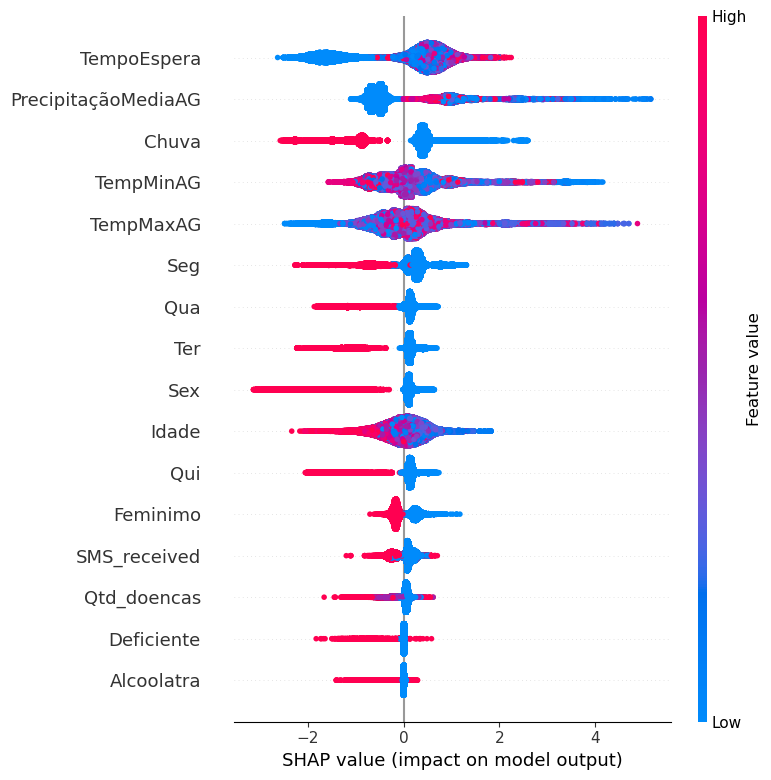

AttributeError: 'NoneType' object has no attribute 'show'

In [56]:
plt.subplots(figsize = (10,8))

shap.summary_plot(shap_values, X_treino)